## K2TranPix tester

In [1]:
#from ipywidgets import interact, interactive, fixed, interact_manual
#import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from astropy.io import fits
from glob import glob

from scipy.signal import convolve2d
from scipy.ndimage.filters import convolve
from astropy.wcs import WCS
from tqdm import tnrange, tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
#%matplotlib inline
#%matplotlib notebook

fig_width_pt = 240.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

from matplotlib import rc
rc('text', usetex=True)
font = {'size'   : 20}
leg = {'fontsize'   : 10}
rc('legend', **leg)

In [27]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

from scipy.signal import convolve2d
from scipy.signal import deconvolve
from scipy.ndimage.filters import convolve

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from glob import glob
import os

from tqdm import tnrange, tqdm_notebook
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

def MinThrustframe(data,thrust):
    mean = np.nanmean(data[thrust+1],axis = 0)
    std = np.nanstd((data[thrust+1] - mean), axis = (1,2))
    Framemin = np.where(std == np.nanmin(abs(std)))[0][0]
    return thrust[Framemin]+1

def DriftKiller(data,thrust):
    # The right value choice here is a bit ambiguous, though it seems that typical variations are <10.
    Drift = (abs(data[thrust+1]-data[thrust-1]) < 10)*1.0 
    Drift[Drift == 0] = np.nan
    j = 0
    for i in range(len(thrust)):
        data[j:thrust[i]] = data[j:thrust[i]]*Drift[i]
        j = thrust[i]
    return data

def FindMinFrame(data):
    # Finding the reference frame
    n_steps = 12
    std_vec = np.zeros(n_steps)
    for i in range(n_steps):
        std_vec[i] = np.nanstd(data[i:-n_steps+i:n_steps,:,:] - data[i+n_steps*80,:,:])
    Framemin = np.where(std_vec==np.nanmin(std_vec))[0][0]
    return Framemin

def ObjectMask(datacube,Framemin):
    # Make a mask of the target object, using the reference frame 
    Mask = datacube[Framemin,:,:]/(np.nanmedian(datacube[Framemin,:,:])+np.nanstd(datacube[Framemin,:,:]))
    Mask[Mask>=1] = np.nan
    Mask[Mask<1] = 1
    # Generate a second mask from remainder of the first. This grabs the fainter pixels around known sources
    Maskv2 = datacube[Framemin,:,:]*Mask/(np.nanmedian(datacube[Framemin,:,:]*Mask)+np.nanstd(datacube[Framemin,:,:]*Mask))
    Maskv2[Maskv2>=1] = np.nan
    Maskv2[Maskv2<1] = 1
    return Maskv2

def ThrustObjectMask(data,thrust):
    StartMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        Start = data[thrust[:3]+1]*StartMask/(np.nanmedian(data[thrust[:3]+1]*StartMask, axis = (1,2))+np.nanstd(data[thrust[:3]+1]*StartMask, axis = (1,2)))[:,None,None]
        Start = Start >= 1
        temp = (np.nansum(Start*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        StartMask = StartMask*temp


    EndMask = np.ones((data.shape[1],data.shape[2]))
    for i in range(2):
        End = data[thrust[-3:]+1]*EndMask/(np.nanmedian(data[thrust[-3:]+1]*EndMask, axis = (1,2))+np.nanstd(data[thrust[-3:]+1]*EndMask, axis = (1,2)))[:,None,None]
        End = End >= 1
        temp = (np.nansum(End*1, axis = 0) >=1)*1.0
        temp[temp>=1] = np.nan
        temp[temp<1] = 1
        EndMask = EndMask*temp
    
        
    Mask = np.nansum([np.ma.masked_invalid(StartMask).mask,np.ma.masked_invalid(EndMask).mask],axis=(0))*1.0
    Mask[Mask!=2] = 1
    Mask[Mask==2] = np.nan
    return Mask



def EventSplitter(events,Times,Masks,framemask):
    Events = []
    times = []
    mask = []
    for i in range(len(events)):
        # Check if there are multiple transients
        Coincident = Masks[events[i]]*framemask[events[i]]*1
        positions = np.where(Coincident == 1)
        if len(positions[0]) > 1:
            for p in range(len(positions[0])):
                eventmask = np.zeros((Masks.shape[1],Masks.shape[2]))
                eventmask[positions[0][p],positions[1][p]] = 1
                eventmask = convolve(eventmask,np.ones((3,3)),mode='constant', cval=0.0)
                Similar = np.where((Masks[Times[i][0]:,:,:]*eventmask == eventmask).all(axis=(1,2)))[0]
                
                if len((np.diff(Similar)<5)) > 1:
                    
                    if len(np.where((np.diff(Similar)<5) == False)[0]) > 0:
                        SimEnd = np.where((np.diff(Similar)<5) == False)[0][0] 
                    else:
                        SimEnd = -1
                else:
                    SimEnd = 0

                Similar = Similar[:SimEnd]
                if len(Similar) > 1:
                    timerange = [Similar[0]+Times[i][0]-1,Similar[-1]+Times[i][0]+1]
                    if len(timerange) > 1:
                        Events.append(events[i])
                        times.append(timerange)
                        mask.append(eventmask)
                
        else:
            Events.append(events[i])
            times.append(Times[i])
            mask.append(Masks[events[i]])
            

    return Events, times, mask

def Asteroid_fitter(Mask,Time,Data, plot = False):
    lc = np.nansum(Data*Mask,axis=(1,2))
    middle = np.where(np.nanmax(lc[Time[0]-1:Time[-1]+1]) == lc)[0][0]
    if abs(Time[0] - Time[1]) < 4:
        x = np.arange(middle-1,middle+1+1,1)
    else:
        x = np.arange(middle-2,middle+2+1,1)
    if x[-1] > len(lc) - 1:
        x = x[x<len(lc)]
    x2 = np.arange(0,len(x),1)
    y = lc[x]
    p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
    p2 = np.poly1d(p1)
    AvLeft = np.nansum(abs(lc[Time[0]:Time[-1]] - p2(np.arange(Time[0],Time[-1]))))/(Time[-1]-Time[0])
    maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
    if (AvLeft < 200) &  (abs(middle - x[maxpoly]) < 2):
        asteroid = True
        if plot == True:
            p2 = np.poly1d(p1)
            plt.figure()
            plt.plot(x,lc[x],'.',label='Event LC')
            plt.plot(x,p2(x),'kx',label='Parabola fit')
            plt.axvspan(Time[0],Time[1], color = 'orange',alpha=0.5, label = 'Event duration')
            plt.ylabel('Counts')
            plt.xlabel('Time')
            plt.legend()
            plt.title('Residual = ' + str(AvLeft))
            plt.savefig('Asteroid_paper_example.pdf')
            
    else:
        asteroid = False

    return asteroid

def Smoothmax(interval,Lightcurve,qual):
    x = np.arange(interval[0],interval[1],1.)
    x[qual[interval[0]:interval[-1]]!=0] = np.nan 
    nbins = int(len(x)/5)
    y = np.copy(Lightcurve[interval[0]:interval[-1]])
    y[qual[interval[0]:interval[-1]]!=0] = np.nan
    
    if np.nansum(x) > 0:
        n, _ = np.histogram(x, bins=nbins,range=(np.nanmin(x),np.nanmax(x)))
        sy, _ = np.histogram(x, bins=nbins, weights=y,range=(np.nanmin(x),np.nanmax(x)))
        sy2, _ = np.histogram(x, bins=nbins, weights=y*y,range=(np.nanmin(x),np.nanmax(x)))
        mean = sy / n
        std = np.sqrt(sy2/n - mean*mean)

        xrange = np.linspace(np.nanmin(x),np.nanmax(x),len(x))
        y_smooth = np.interp(xrange, (_[1:] + _[:-1])/2, mean)
        y_smooh_error = np.interp(xrange, (_[1:] + _[:-1])/2, std)

        temp = np.copy(y)
        temp[y_smooh_error>10] =np.nan

        maxpos = np.where(temp == np.nanmax(temp))[0]+interval[0]
    else:
        maxpos = 0
    return maxpos

def ThrusterElim(Events,Times,Masks,Firings,Quality,qual,Data):
    temp = []
    temp2 = []
    temp3 = []
    asteroid = []
    asttime = []
    astmask = []
    for i in range(len(Events)):
        Range = Times[i][-1] - Times[i][0]
        if (Range > 0) & (Range/Data.shape[0] < 0.8) & (Times[i][0] > 5): 
            begining = Firings[(Firings >= Times[i][0]-2) & (Firings <= Times[i][0]+1)]
            if len(begining) == 0:
                begining = Quality[(Quality == Times[i][0])] #& (Quality <= Times[i][0]+1)]
            end = Firings[(Firings >= Times[i][-1]-1) & (Firings <= Times[i][-1]+2)]
            if len(end) == 0:
                end = Quality[(Quality == Times[i][-1])] #& (Quality <= Times[i][-1]+1)]
            eventthrust = Firings[(Firings >= Times[i][0]) & (Firings <= Times[i][-1])]

            if (~begining.any() & ~end.any()) & (len(eventthrust) < 3):
                
                if Asteroid_fitter(Masks[i],Times[i],Data):
                    asteroid.append(Events[i])
                    asttime.append(Times[i])
                    astmask.append(Masks[i])
                else:
                    LC = np.nansum(Data[Times[i][0]:Times[i][-1]+3]*Masks[i], axis = (1,2))
                    if (np.where(np.nanmax(LC) == LC)[0] < Range).all():
                    
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])

            elif len(eventthrust) >= 3:

                if begining.shape[0] == 0:
                    begining = 0
                else:
                    begining = begining[0]   
                if end.shape[0] == 0:
                    end = Times[i][-1] + 10
                else:
                    end = end[0]
                LC = np.nansum(Data*Masks[i], axis = (1,2))
                maxloc = Smoothmax(Times[i],LC,qual)

                if ((maxloc > begining).all() & (maxloc < end)).all(): 
                    premean = np.nanmean(LC[eventthrust-1]) 
                    poststd = np.nanstd(LC[eventthrust+1])
                    postmean = np.nanmedian(LC[eventthrust+1])
                    Outsidethrust = Firings[(Firings < Times[i][0]) | (Firings > Times[i][-1]+20)]
                    Outsidemean = np.nanmedian(LC[Outsidethrust+1])
                    Outsidestd = np.nanstd(LC[Outsidethrust+1])
                    if  postmean > Outsidemean+2*Outsidestd:
                        temp.append(Events[i])
                        temp2.append(Times[i])
                        temp3.append(Masks[i])


    events = np.array(temp)
    eventtime = np.array(temp2)
    eventmask = np.array(temp3)
    return events, eventtime, eventmask, asteroid, asttime, astmask


def pix2coord(x,y,mywcs):
    wx, wy = mywcs.wcs_pix2world(x, y, 0)
    return np.array([float(wx), float(wy)])

def Get_gal_lat(mywcs,datacube):
    ra, dec = mywcs.wcs_pix2world(int(datacube.shape[1]/2), int(datacube.shape[2]/2), 0)
    b = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs').galactic.b.degree
    return b

def Save_space(Save,File):
    try:
        
        if not os.path.exists(Save+File.split('K2/')[-1]):
            os.makedirs(Save+File.split('K2/')[-1].split('ktwo')[0])
    except FileExistsError:
        pass

def K2TranPixFig(Events,Eventtime,Eventmask,Data,Time,Frames,wcs,Save,File,Quality,Thrusters,Framemin,Datacube):
    for i in range(len(Events)):
            # Check if there are multiple transients
            #Find Coords of transient
            position = np.where(Eventmask[i])

            maxcolor = np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1],(Eventmask[i]==1)])
            
            Mid = np.where(Data[Eventtime[i][0]:Eventtime[i][-1],(Eventmask[i]==1)] == maxcolor)
            
            Coord = pix2coord(Mid[1],Mid[0],wcs)
            # Generate a light curve from the transient masks
            LC = np.nansum(Data*Eventmask[i], axis = (1,2))
            BG = Data*~Frames[Events[i]]
            BG[BG <= 0] =np.nan
            BGLC = np.nanmedian(BG, axis = (1,2))
            
            Obj = np.ma.masked_invalid(Data[Framemin]).mask
            ObjLC = np.nansum(Datacube*Obj,axis = (1,2))
            ObjLC = ObjLC*np.nanmax(LC)/np.nanmax(ObjLC)
            
            
            fig = plt.figure(figsize=(10,6))
            # set up subplot grid
            gridspec.GridSpec(2,3)

            # large subplot
            plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
            plt.title('Event light curve (BJD '+str(round(Time[Eventtime[i][0]]-Time[0],2))+', RA '+str(round(Coord[0],3))+', DEC '+str(round(Coord[1],3))+')')
            plt.xlabel('Time (+'+str(Time[0])+' BJD)')
            plt.ylabel('Counts')
            plt.plot(Time - Time[0], LC,'.', label = 'Event LC')
            plt.plot(Time - Time[0], BGLC,'k.', label = 'Background LC')
            plt.plot(Time - Time[0], ObjLC,'kx', label = 'Scalled object LC')
            plt.axvspan(Time[Eventtime[i][0]]-Time[0],Time[Eventtime[i][-1]]-Time[0], color = 'orange', label = 'Event duration')
            plt.axvline(Time[Quality[0]]-Time[0],color = 'red', linestyle='dashed',label = 'Quality', alpha = 0.5)
            for j in range(Quality.shape[0]-1):
                j = j+1 
                plt.axvline(Time[Quality[j]]-Time[0], linestyle='dashed', color = 'red', alpha = 0.5)
            # plot Thurster firings 
            plt.axvline(Time[Thrusters[0]]-Time[0],color = 'red',label = 'Thruster', alpha = 0.5)
            for j in range(Thrusters.shape[0]-1):
                j = j+1 
                plt.axvline(Time[Thrusters[j]]-Time[0],color = 'red', alpha = 0.5)
            xmin = Time[Eventtime[i][0]]-Time[0]-(Eventtime[i][-1]-Eventtime[i][0])/10
            xmax = Time[Eventtime[i][-1]]-Time[0]+(Eventtime[i][-1]-Eventtime[i][0])/10
            if xmin < 0:
                xmin = 0
            if xmax > Time[-1] - Time[0]:
                xmax = Time[-1] - Time[0]
            plt.xlim(xmin,xmax) # originally 48 for some reason
            plt.ylim(0,np.nanmax(LC[Eventtime[i][0]:Eventtime[i][-1]])+0.1*np.nanmax(LC[Eventtime[i][0]:Eventtime[i][-1]]))
            plt.legend(loc = 1)
            # small subplot 1 Reference image plot
            plt.subplot2grid((2,3), (0,2))
            plt.title('Reference')
            plt.imshow(Data[Framemin,:,:], origin='lower',vmin=0,vmax = maxcolor)
            current_cmap = plt.cm.get_cmap()
            current_cmap.set_bad(color='black')
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.plot(position[1],position[0],'r.',ms = 15)
            # small subplot 2 Image of event
            plt.subplot2grid((2,3), (1,2))
            plt.title('Event')
            plt.imshow(Data[np.where(Data*Eventmask[i]==np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1]]*Eventmask[i]))[0][0],:,:], origin='lower',vmin=0,vmax = maxcolor)
            current_cmap = plt.cm.get_cmap()
            current_cmap.set_bad(color='black')
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.plot(position[1],position[0],'r.',ms = 15)
            # fit subplots and save fig
            fig.tight_layout()
            #fig.set_size_inches(w=11,h=7)
            Save_space(Save+'Figures/',File)
            
            plt.savefig(Save+'Figures/'+File.split('/')[-1].split('-')[0]+'_'+str(i)+'.pdf', bbox_inches = 'tight');


import matplotlib.animation as animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def K2TranPixGif(Events,Eventtime,Eventmask,Data,wcs,Save,File):
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
    for i in range(len(Events)):
        position = np.where(Eventmask[i])
        
        maxcolor = np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1],(Eventmask[i] == 1)])

        xmin = Eventtime[i][0]-(Eventtime[i][1]-Eventtime[i][0])
        xmax = Eventtime[i][1]+(Eventtime[i][1]-Eventtime[i][0])
        if xmin < 0:
            xmin = 0
        if xmax > len(Data):
            xmax = len(Data)-1
        Section = Data[int(xmin):int(xmax),:,:]
        fig = plt.figure()
        fig.set_size_inches(6,6)
        ims = []
        for j in range(Section.shape[0]):
            im = plt.imshow(Section[j], origin='lower',vmin = 0, vmax = maxcolor, animated=True)
            plt.plot(position[1],position[0],'r.',ms = 15)
            ims.append([im])
        plt.title(File.split('/')[-1].split('-')[0]+' Event # '+str(i))
        ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat = False)
        c = plt.colorbar(fraction=0.046, pad=0.04)
        c.set_label('Counts')
        
        Save_space(Save+'Figures/',File)
        ani.save(Save+'Figures/'+File.split('/')[-1].split('-')[0]+'_Event_#_'+str(i)+'.mp4',dpi=300)
        plt.close()


%run '/Users/ryanr/Documents/PhD/coding/Kepler/pipelines/Injections/K2MagLimit.ipynb'

In [ ]:
'/Volumes/TOSHIBA EXt/K2/c6/212300000/16000/ktwo212316559-c06_lpd-targ.fits.gz'

In [ ]:
'/Volumes/TOSHIBA EXt/K2/c6/212200000/67000/ktwo212267079-c06_lpd-targ.fits.gz'#

in


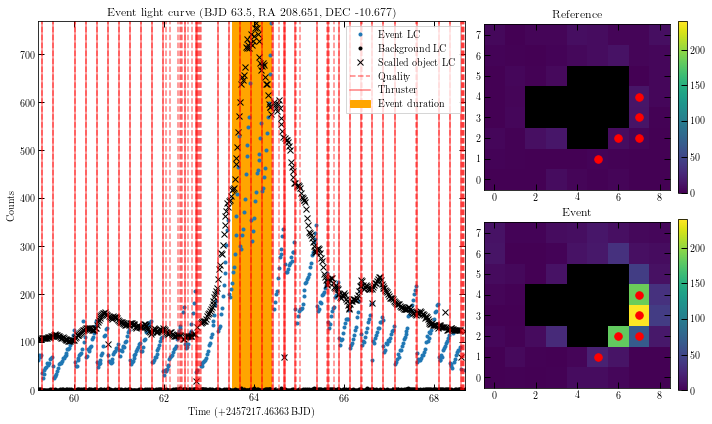

In [28]:
pixelfile = '/Volumes/TOSHIBA EXt/K2/c06/212500000/95000/ktwo212595811-c06_lpd-targ.fits.gz'
save = '/Users/ryanr/Documents/PhD/coding/Kepler/K2/'

try:
    
    hdu = fits.open(pixelfile)
    dat = hdu[1].data
    datacube = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data#np.copy(testdata)#
    
    if datacube.shape[1] > 1 and datacube.shape[2] > 1:
        print('in')
        time = dat["TIME"] + 2454833.0
        #datacube[:,6,2] += K2Steptest(22,3,time,1118)
        Qual = hdu[1].data.field('QUALITY')
        thrusters = np.where((Qual == 1048576) | (Qual == 1089568) | (Qual == 1056768) | (Qual == 1064960) | (Qual == 1081376) | (Qual == 10240) | (Qual == 32768) )[0]
        quality = np.where((Qual != 0))[0]
        #calculate the reference frame
        Framemin = FindMinFrame(datacube)
        # Apply object mask to data
        Mask = ThrustObjectMask(datacube,thrusters)
        
        Maskdata = datacube*Mask
        #Maskdata[Maskdata<0] = 0 

        #Motion control
        #Conv = convolve2d(np.ma.masked_invalid(Mask).mask, np.ones((3,3)), mode="same")
        #Maskdata = Maskdata*(Conv < 2)

        # Make a mask for the object to use as a test to eliminate very bad pointings
        obj = np.ma.masked_invalid(Mask).mask
        objmed = np.nanmedian(datacube[thrusters+1]*obj,axis=(0))
        objstd = np.nanstd(datacube[thrusters+1]*obj,axis=(0))
        Maskdata[(np.nansum(datacube*obj,axis=(1,2)) < np.nansum(objmed-3*objstd)),:,:] = np.nan

        #overflow = ((convolve(Maskdata[(np.nansum(datacube*obj,axis=(1,2)) > np.nansum(objmed+2*objstd)),:,:],
                              #np.ones((1,1,2)), mode='constant', cval=0.0)) >= 1)*1.0
        #overflow[overflow == 1] = np.nan
        #overflow[overflow == 0] = 1
        #Maskdata[(np.nansum(datacube*obj,axis=(1,2)) > np.nansum(objmed+2*objstd)),:,:] = overflow
        #Maskdata[Maskdata > 170000] = np.nan
        #Stdframe = np.ones(Maskdata.shape)
        framemask = np.zeros(Maskdata.shape)

        #Index = (np.nansum(datacube*obj,axis=(1,2))>np.nansum(objmed-3*objstd)) #((np.nanstd(Maskdata,axis=(1,2)) > np.nanmedian(stddist)) & ((Maskdata.shape[1]>1) & (Maskdata.shape[2]>1))) 
        #framemask[Index] = (Maskdata[Index]/(np.nanmedian(Maskdata[Index])+2*(np.nanstd(Maskdata[Index])))) >= 1
        framemask = ((Maskdata/abs(np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))) >= 1)
        framemask[:,np.where(Maskdata > 100000)[1],np.where(Maskdata > 100000)[2]] = 0
        #Index = ((np.nanstd(Maskdata) > np.nanmedian(stddist)+np.nanstd(stddist)) & ((Maskdata.shape[1]==1) | (Maskdata.shape[2] == 1))) 

        # Identify if there is a sequence of consecutive or near consecutive frames that meet condtition 
        #Eventmask = (convolve(framemask,np.ones((5,3,3)),mode='constant', cval=0.0) >= 3)

        Eventmask_ref = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
        Eventmask = np.copy(Eventmask_ref)
        Eventmask[~np.where((convolve(Eventmask_ref,np.ones((5,1,1)),mode='constant', cval=0.0) >= 4))[0]] = 0
        Eventmask[Qual!=0,:,:] = False
        Eventmask_ref[Qual!=0,:,:] = False
        #print(Eventmask[Time+1])

        Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]


        events = []
        eventtime = []
        while len(Index) > 1:

            similar = np.where(((Eventmask[Index[0]]*Eventmask_ref[Index[0]:]) == Eventmask[Index[0]]).all(axis = (1,2)))[0]+Index[0]

            if len((np.diff(similar)<5)) > 1:



                if len(np.where((np.diff(similar)<5) == False)[0]) > 0:
                    simEnd = np.where((np.diff(similar)<5) == False)[0][0] 
                else:
                    simEnd = -1
            else:
                simEnd = 0
            if (simEnd > 0):
                similar = similar[:simEnd]
            elif (simEnd == 0):
                similar = np.array([similar[0]])

            if len(similar) > 1:

                events.append(similar[0])
                temp = [similar[0]-1,similar[-1]+1]
                eventtime.append(temp)
                temp = []
            template = Eventmask[Index[0]]
            for number in similar:
                if (np.nansum(template*1-Eventmask[number]*1) == 0):
                    Index = np.delete(Index, np.where(Index == number)[0])

        events, eventtime, eventmask = EventSplitter(events,eventtime,Eventmask,framemask)  
        
        events = np.array(events)
        eventmask = np.array(eventmask)
        eventtime = np.array(eventtime)
        
        temp = []
        for i in range(len(events)):
            if len(np.where(datacube[eventtime[i][0]:eventtime[i][-1]]*eventmask[i] > 100000)[0]) == 0:
                temp.append(i)
        eventtime = eventtime[temp]
        events = events[temp]
        eventmask = eventmask[temp]
        
        middle = (convolve(eventmask,np.ones((1,3,3))) == np.nanmax(convolve(eventmask,np.ones((1,3,3))))) & (convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0) == np.nanmax(convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0)))
        eventmask = eventmask*middle
        #eventtime = np.array(eventtime)


        # Eliminate events that begin/end within 2 cadences of a thruster fire
        events, eventtime, eventmask = EventSplitter(events,eventtime,Eventmask,framemask)  
        events = np.array(events)
        eventmask = np.array(eventmask)
        if len(eventmask) > 0:
            middle = (convolve(eventmask,np.ones((1,3,3))) == np.nanmax(convolve(eventmask,np.ones((1,3,3))))) & (convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0) == np.nanmax(convolve(eventmask,np.ones((1,3,3)),mode='constant', cval=0.0)))
            eventmask = eventmask*middle
        #eventtime = np.array(eventtime)


        # Eliminate events that begin/end within 2 cadences of a thruster fire
        events, eventtime, eventmask, asteroid, asttime, astmask = ThrusterElim(events,eventtime,eventmask,thrusters,quality,Qual,Maskdata)
        events = np.array(events)
        eventtime = np.array(eventtime)
        eventmask = np.array(eventmask)

        
        coincident = []
        i = 0
        while i < len(events):
            coincident = ((eventtime[:,0] >= eventtime[i,0]-1) & (eventtime[:,0] <= eventtime[i,0]+1) & (eventtime[:,1] >= eventtime[i,1]-1) & (eventtime[:,1] <= eventtime[i,1]+1))       
            if sum(coincident*1) > 1:
                newmask = (np.nansum(eventmask[coincident],axis = (0)) > 0)*1 

                events = np.delete(events,np.where(coincident[1:])[0])
                eventtime = np.delete(eventtime,np.where(coincident[1:])[0], axis = (0))
                eventmask = np.delete(eventmask,np.where(coincident[1:])[0], axis = (0))
                eventmask[i] = newmask

            i +=1


        # Create an array that saves the total area of mask and time. 
        # 1st col pixelfile, 2nd duration, 3rd col area, 4th col number of events, 5th 0 if in galaxy, 1 if outside
        Result = np.zeros(5)
        # Define the coordinate system 
        funny_keywords = {'1CTYP4': 'CTYPE1',
                          '2CTYP4': 'CTYPE2',
                          '1CRPX4': 'CRPIX1',
                          '2CRPX4': 'CRPIX2',
                          '1CRVL4': 'CRVAL1',
                          '2CRVL4': 'CRVAL2',
                          '1CUNI4': 'CUNIT1',
                          '2CUNI4': 'CUNIT2',
                          '1CDLT4': 'CDELT1',
                          '2CDLT4': 'CDELT2',
                          '11PC4': 'PC1_1',
                          '12PC4': 'PC1_2',
                          '21PC4': 'PC2_1',
                          '22PC4': 'PC2_2'}
        mywcs = {}
        for oldkey, newkey in funny_keywords.items():
            mywcs[newkey] = hdu[1].header[oldkey] 
        mywcs = WCS(mywcs)

        # Check if in the galaxy plane -20 < b < 20
        b = Get_gal_lat(mywcs,datacube)
        if (float(b) > -20) and (float(b) < 20):
            Result[4] = 0 
        else:
            Result[4] = 1
        # Check through each of the identified frame sets to see if there is anything and save a figure if so
        K2TranPixFig(events,eventtime,eventmask,Maskdata,time,Eventmask,mywcs,save,pixelfile,quality,thrusters,Framemin,datacube)
        #K2TranPixGif(events,eventtime,eventmask,Maskdata,mywcs,save,pixelfile)
    else:
        Result = np.ones(5)*np.nan
except (OSError):
    Result = np.ones(5)*-1


<IPython.core.display.Javascript object>


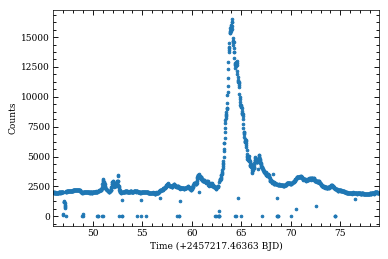

In [436]:
ObjLC = np.nansum(datacube*obj,axis = (1,2))
plt.figure()
plt.plot(time-time[0],ObjLC,'.')
plt.xlim(46,time[-1]-time[0])
plt.xlabel('Time (+'+str(time[0])+' BJD)')
plt.ylabel('Counts')
plt.tight_layout()
plt.minorticks_on()
plt.savefig(save+'212595811_Obj.pdf')

In [418]:
Asteroid_fitter(eventmask,eventtime[0],Maskdata,True)

False

In [356]:
Obj = np.ma.masked_invalid(Maskdata[Framemin]).mask
ObjLC = np.nansum(Data*Obj,axis = (1,2))
ObjLC = ObjLC*np.nanmax(LC)/np.nanmax(ObjLC)

IndentationError: unexpected indent (<ipython-input-356-54f5413833db>, line 2)

In [349]:
coincident = []
i = 0
while i < len(events):
    coincident = ((eventtime[:,0] >= eventtime[i,0]-1) & (eventtime[:,0] <= eventtime[i,0]+1) & (eventtime[:,1] >= eventtime[i,1]-1) & (eventtime[:,1] <= eventtime[i,1]+1))       
    if coincident.any():
        newmask = (np.nansum(eventmask[coincident],axis = (0)) > 0)*1 
        
        events = np.delete(events,np.where(coincident[1:])[0])
        eventtime = np.delete(eventtime,np.where(coincident[1:])[0], axis = (0))
        eventmask = np.delete(eventmask,np.where(coincident[1:])[0], axis = (0))
        eventmask[i] = newmask

    i +=1

In [350]:
eventmask

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]])

<IPython.core.display.Javascript object>


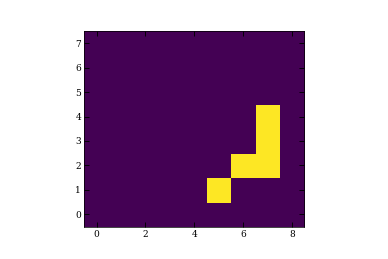

In [348]:
plt.figure()
plt.imshow(eventmask[0],origin='lower')

In [186]:
len(x)

42

In [262]:
def K2TranPixFig(Events,Eventtime,Eventmask,Data,Time,Frames,wcs,Save,File,Quality,Thrusters,Framemin):
    for i in range(len(Events)):
            # Check if there are multiple transients
            #Find Coords of transient
            position = np.where(Eventmask[i])
            if len(position[0]) == 9:
                middle = convolve(Eventmask[i],np.ones((3,3)),mode='constant', cval=0.0) == np.nanmax(convolve(Eventmask[i],np.ones((3,3)),mode='constant', cval=0.0))
            else:
                middle = (convolve(Eventmask[i],np.ones((3,3))) == np.nanmax(convolve(Eventmask[i],np.ones((3,3))))) & (convolve(Eventmask[i],np.ones((3,3)),mode='constant', cval=0.0) == np.nanmax(convolve(Eventmask[i],np.ones((3,3)),mode='constant', cval=0.0)))
            Mid = np.where(middle)

            maxcolor = np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1],middle])
            Coord = pix2coord(Mid[0],Mid[1],wcs)
            Eventmask2 = middle
            # Generate a light curve from the transient masks
            LC = np.nansum(Data*Eventmask2, axis = (1,2))
            BG = Data*~Frames[Events[i]]
            BG[BG <= 0] =np.nan
            BGLC = np.nanmedian(BG, axis = (1,2))
            
            
            fig = plt.figure(figsize=(10,6))
            # set up subplot grid
            gridspec.GridSpec(2,3)

            # large subplot
            plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2)
            plt.title('Masked light curve (BJD '+str(round(Time[Eventtime[i][0]]-Time[0],2))+', RA '+str(round(Coord[0],3))+', DEC '+str(round(Coord[1],3))+')')
            plt.xlabel('Time (+'+str(Time[0])+' BJD)')
            plt.ylabel('Flux')
            plt.plot(Time - Time[0], LC,'.', label = 'Event LC')
            plt.plot(Time - Time[0], BGLC,'k.', label = 'Background LC')
            plt.axvspan(Time[Eventtime[i][0]]-Time[0],Time[Eventtime[i][-1]]-Time[0], color = 'orange', label = 'Event duration')
            plt.axvline(Time[Quality[0]]-Time[0],color = 'red', linestyle='dashed',label = 'Quality', alpha = 0.5)
            for j in range(Quality.shape[0]-1):
                j = j+1 
                plt.axvline(Time[Quality[j]]-Time[0], linestyle='dashed', color = 'red', alpha = 0.5)
            # plot Thurster firings 
            plt.axvline(Time[Thrusters[0]]-Time[0],color = 'red',label = 'Thruster', alpha = 0.5)
            for j in range(Thrusters.shape[0]-1):
                j = j+1 
                plt.axvline(Time[Thrusters[j]]-Time[0],color = 'red', alpha = 0.5)
            xmin = Time[Eventtime[i][0]]-Time[0]-(Eventtime[i][-1]-Eventtime[i][0])/10
            xmax = Time[Eventtime[i][-1]]-Time[0]+(Eventtime[i][-1]-Eventtime[i][0])/10
            if xmin < 0:
                xmin = 0
            if xmax > Time[-1] - Time[0]:
                xmax = Time[-1] - Time[0]
            plt.xlim(xmin,xmax) # originally 48 for some reason
            plt.ylim(0,np.nanmax(LC[Eventtime[i][0]:Eventtime[i][-1]])+0.1*np.nanmax(LC[Eventtime[i][0]:Eventtime[i][-1]]))
            plt.legend(loc = 1)
            # small subplot 1 Reference image plot
            plt.subplot2grid((2,3), (0,2))
            plt.title('Reference')
            plt.imshow(Data[Framemin,:,:], origin='lower',vmin=0,vmax = maxcolor)
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.plot(Mid[1],Mid[0],'r.',ms=15)
            # small subplot 2 Image of event
            plt.subplot2grid((2,3), (1,2))
            plt.title('Event')
            plt.imshow(Data[np.where(Data*Eventmask2==np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1]]*Eventmask2))[0][0],:,:], origin='lower',vmin=0,vmax = maxcolor)
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.plot(Mid[1],Mid[0],'r.',ms = 15)
            # fit subplots and save fig
            fig.tight_layout()
            #fig.set_size_inches(w=11,h=7)
            plt.savefig(Save+File.split('/')[-1].split('-')[0]+'_'+str(i)+'.pdf', bbox_inches = 'tight')

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.]]
[[False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False  True False]]
(array([6]), array([6]))


<IPython.core.display.Javascript object>


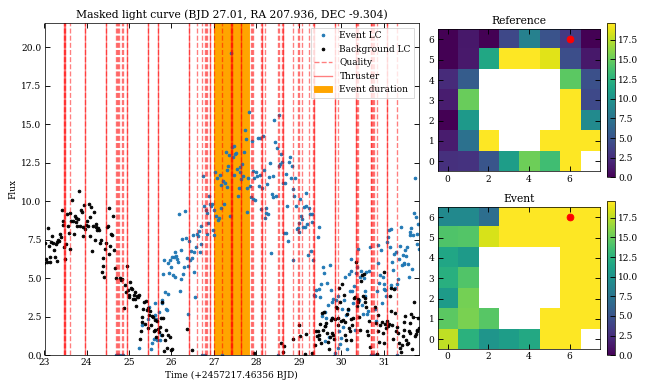

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  1.]]
[[False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False  True]]
(array([6]), array([7]))


<IPython.core.display.Javascript object>


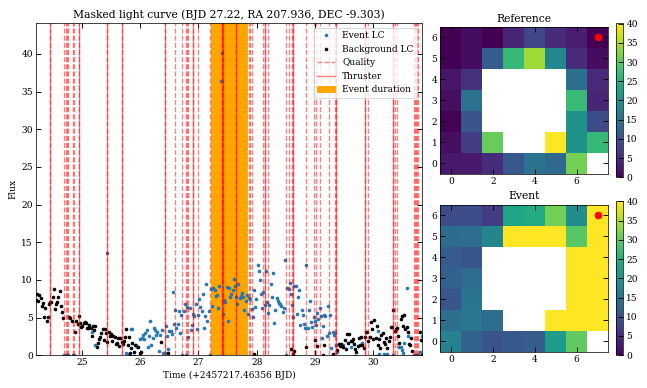

[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  1.  1.]]
[[False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False False False]
 [False False False False False False  True False]]
(array([6]), array([6]))


<IPython.core.display.Javascript object>


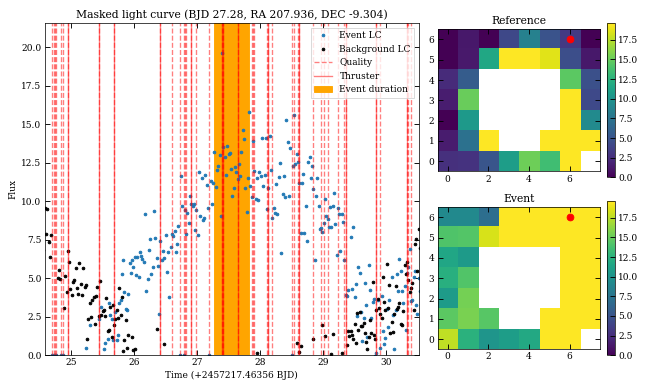

In [263]:
K2TranPixFig(events,eventtime,eventmask,Maskdata,time,Eventmask,mywcs,save,pixelfile,quality,thrusters,Framemin)

In [230]:
eventmask

array([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]])

In [ ]:
import matplotlib.animation as animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook

fig = plt.figure()#figsize=(10,10))
j=0
#thingy = np.nansum(Maskdata,axis = (1,2)) != 0
test = Maskdata[asttime[j][0]+2:asttime[j][1]+20,:,:]
Maskdata2 = test#/((np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))))>=1#[Framemin::12]
im = plt.imshow(Maskdata2[0,:,:], origin='lower', animated=True)
i = 0
def updatefig(*args):
    global i
    if i<Maskdata2.shape[0]+1:
        i+=1
        
    im.set_array(Maskdata2[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=60, blit=True)
plt.colorbar();

In [8]:
np.ma.array(Maskdata[0])

masked_array(data =
 [[ 13.3083477   -4.96059895   8.55465603   5.88596344   4.90108776
    6.14218235   6.36645889   4.04397392   1.69384432  -0.44027072]
 [ 10.4280262    0.8405841    7.37841558  11.12265396  12.67947769
   11.85769653   6.72208929   5.62848759   1.89620221   0.26283732]
 [ 12.42952728   0.55402702   8.28678703  16.03860474          nan
           nan          nan  12.17717171   2.47001815   1.21735215]
 [ 12.91214085   3.39557099   8.47312069          nan          nan
           nan          nan          nan   6.40865374  -2.45599246]
 [ 14.04846096   2.76775908  11.71184063  22.86330032          nan
           nan          nan          nan   9.11726284   5.45488262]
 [ 10.83797741   2.31706285   6.67759466  12.23800755          nan
           nan          nan          nan  13.13718796   7.79283094]
 [ 13.78010464  -0.31174523   5.60073519   9.31811047  19.29286385
           nan          nan          nan  14.51183033   4.53014708]
 [ 10.58798313   0.47546774   7.66

In [94]:
import matplotlib.animation as animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def animate(i):
    im.set_array(Section[i])  # update the data
    return im,

def init():
    im.set_array(np.zeros((Section.shape[1],Section.shape[2])))
    return im,

def K2TranPixGif(Events,Eventtime,Eventmask,Data,wcs,Save,File):
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
    for i in range(len(Events)):
        position = np.where(Eventmask[i])
        middle = int(np.ceil(np.nansum(Eventmask[i])/2)) - 1
        maxframe = np.where(Data[:,position[0][middle],position[1][middle]]*Eventmask[i,position[0][middle],position[1][middle]]==np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1],position[0][middle],position[1][middle]]*Eventmask[i,position[0][middle],position[1][middle]]))[0][0]
        maxcolor = np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1],position[0][middle],position[1][middle]])

        xmin = Eventtime[i][0]-(Eventtime[i][1]-Eventtime[i][0])
        xmax = Eventtime[i][1]+(Eventtime[i][1]-Eventtime[i][0])
        if xmin < 0:
            xmin = 0
        if xmax > len(Data):
            xmax = len(Data)-1
        Section = Data[int(xmin):int(xmax),:,:]
        fig = plt.figure()
        fig.set_size_inches(6,6)
        ims = []
        for j in range(Section.shape[0]):
            im = plt.imshow(Section[j], origin='lower',vmin = 0, vmax = maxcolor, animated=True)
            plt.plot(position[1],position[0],'r.')
            ims.append([im])
        plt.title(File.split('/')[-1].split('-')[0]+' Event # '+str(i))
        ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat = False)
        c = plt.colorbar(fraction=0.046, pad=0.04)
        c.set_label('Counts')
        
        ani.save(File.split('/')[-1].split('-')[0]+'_Event_#_'+str(i)+'.mp4',dpi=300)
        plt.close()

<IPython.core.display.Javascript object>


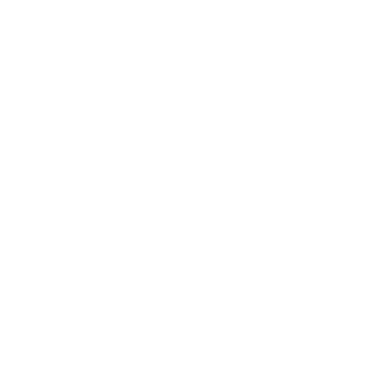

In [95]:
K2TranPixGif(events,eventtime,eventmask,Maskdata,mywcs,save,pixelfile)

<IPython.core.display.Javascript object>


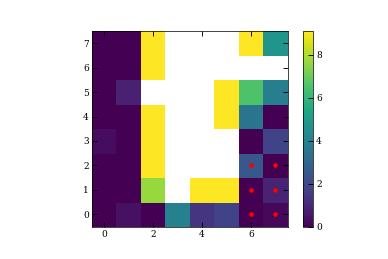

AxesImage(43.2,36;345.6x217.44)


In [143]:
Eventtime = eventtime
Eventmask = eventmask
Events = events
Data = Maskdata

Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
for i in range(len(Events)):
    position = np.where(Eventmask[i])
    middle = convolve(Eventmask[i],np.ones((3,3))) == np.nanmax(convolve(Eventmask[i],np.ones((3,3))))
    maxcolor = np.nanmax(Data[Eventtime[i][0]:Eventtime[i][-1],middle])

    xmin = Eventtime[i][0]-(Eventtime[i][1]-Eventtime[i][0])
    xmax = Eventtime[i][1]+(Eventtime[i][1]-Eventtime[i][0])
    if xmin < 0:
        xmin = 0
    if xmax > len(Data):
        xmax = len(Data)-1
    Section = Data[int(xmin):int(xmax),:,:]
    fig = plt.figure()
    ims = []
    for j in range(Section.shape[0]):
        im = plt.imshow(Section[j], origin='lower',vmin = 0, vmax = maxcolor, animated=True)
        plt.plot(position[1],position[0],'r.')
        ims.append([im])
        
    print(im)
    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat = False)
    plt.colorbar()

In [80]:
Data[Eventtime[i][0]:Eventtime[i][-1],position[0][middle],position[1][middle]]

array([ 4.2038517 ,  7.56695843,  7.61240005])

In [130]:
middle

array([[False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False, False]], dtype=bool)

<IPython.core.display.Javascript object>


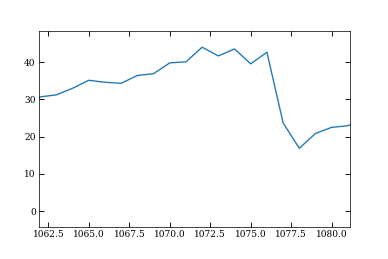

In [110]:
thing = Maskdata[:,position[0][middle],position[1][middle]]
plt.figure()
plt.plot(thing)

In [111]:
eventtime

array([[1071, 1075]])

In [ ]:
def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

def Dothing():
    fig = plt.figure()


    def f(x, y):
        return np.sin(x) + np.cos(y)

    x = np.linspace(0, 2 * np.pi, 120)
    y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

    im = plt.imshow(f(x, y), animated=True)

    ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
    

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
for i in range(len(events)):

    position = np.where(eventmask[i])
    middle = int(np.ceil(np.nansum(eventmask[i])/2))
    maxcolor = np.nanmax(Maskdata[eventtime[i][0]:eventtime[i][-1],position[0][middle],position[1][middle]])

    xmin = eventtime[i][0]-(eventtime[i][1]-eventtime[i][0])
    xmax = eventtime[i][1]+(eventtime[i][1]-eventtime[i][0])
    if xmin < 0:
        xmin = 0
    if xmax > len(Maskdata):
        xmax = len(Maskdata)-1
    Section = Maskdata[int(xmin):int(xmax),:,:]

    fig = plt.figure()
    im = plt.imshow(Section[0,:,:], origin='lower',vmin = 0, vmax = maxcolor,  animated=True)
    plt.plot(position[1],position[0],'r.')

    z= 0 
    print(z)
    def updatefig(*args):
        global z
        print(z)
        if z<Section.shape[0]+1:
            z+=1

        im.set_array(Section[z])
        return im,
    ani = animation.FuncAnimation(fig, updatefig, interval=60, frames=(xmax-xmin), blit=True)
    plt.colorbar();

In [ ]:
%who

In [ ]:
import matplotlib.animation as animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook

fig = plt.figure()#figsize=(10,10))
j=0
#thingy = np.nansum(Maskdata,axis = (1,2)) != 0
test = Maskdata[eventtime[j][0]-2:eventtime[j][1]+20,:,:]
Maskdata2 = test#/((np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))))>=1#[Framemin::12]
im = plt.imshow(Maskdata2[0,:,:], origin='lower',vmin = 0, vmax = maxcolor, animated=True)
plt.plot(position[1],position[0],'r.')
i = 0
def updatefig(*args):
    global i
    if i<Maskdata2.shape[0]+1:
        i+=1
        
    im.set_array(Maskdata2[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=60, frames=(xmax-xmin), blit=True)
plt.colorbar();
#ani.save(save+pixelfile.split('/')[-1].split('-')[0]+'_'+'.gif',writer='imagemagick');
#plt.figure()
#plt.imshow(eventmask[j],origin='lower')


In [ ]:
ast = {}
ast[pixelfile.split('ktwo')[-1].split('-')[0]] = {}
ast[pixelfile.split('ktwo')[-1].split('-')[0]]['Asteroids'] = asteroid
ast[pixelfile.split('ktwo')[-1].split('-')[0]]['Time'] = asttime
ast[pixelfile.split('ktwo')[-1].split('-')[0]]['Mask'] = astmask

In [ ]:
ast[pixelfile.split('ktwo')[-1].split('-')[0]].keys()

In [ ]:
ast = {}
ast['Asteroids'] = asteroid
ast['Time'] = asttime
ast['Mask'] = astmask

astsave = '/Users/ryanr/Documents/PhD/coding/Kepler/K2/' + pixelfile.split('-')[1].split('_')[0] + '/Asteroid/' + pixelfile.split('ktwo')[-1].split('-')[0]+'_Asteroid.npy'
np.save(astsave,ast)

In [ ]:
pixelfile.split('-')[1].split('_')[0]

In [ ]:
lc = np.nansum(Maskdata*eventmask,axis=(1,2))
middle = np.where(np.nanmax(lc[eventtime[0,0]-1:eventtime[0,-1]+1]) == lc)[0][0]
x = np.arange(middle-3,middle+3+1,1)
x2 = np.arange(0,len(x),1)
y = lc[x]
p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)

In [ ]:
residual

In [ ]:
def Asteroid_fitter(Mask,Time,Data, plot = False):
    lc = np.nansum(Data*Mask,axis=(1,2))
    middle = np.where(np.nanmax(lc[Time[0]-1:Time[-1]+1]) == lc)[0][0]
    x = np.arange(middle-2,middle+2+1,1)
    x2 = np.arange(0,len(x),1)
    y = lc[[np.arange(middle-2,middle+2+1,1)]]
    p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
    p2 = np.poly1d(p1)
    maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
    print(middle)
    print(x[maxpoly])
    print(residual)
    p2 = np.poly1d(p1)
    plt.figure()
    plt.plot(x,lc[x],'.')
    plt.plot(x,p2(x),'.')
    plt.ylabel('Counts')
    plt.xlabel('Time')
    plt.title('Residual = ' + str(residual))
    if (residual < 2000) &  (abs(middle - x[maxpoly]) < 2):
        asteroid = True
    else:
        asteroid = False
        
    return asteroid 
Asteroid_fitter(eventmask[0],eventtime[0],Maskdata,True)

In [ ]:
asteroid

In [ ]:
plt.close()
counter = 0
for i in range(len(events)):
    # Check if there are multiple transients
    #Find Coords of transient
    position = np.where(eventmask[i])
    middle = int(np.ceil(np.nansum(eventmask[i])/2))
    Coord = pix2coord(position[0][middle],position[1][middle],mywcs)

    # Generate a light curve from the transient masks
    LC = np.nansum(Maskdata*eventmask[i], axis = (1,2))
    BG = Maskdata*~Eventmask[events[i]]
    BG[BG <= 0] =np.nan
    BGLC = np.nanmedian(BG, axis = (1,2))

    maxcolor = np.nanmax(Maskdata[eventtime[i][0]:eventtime[i][-1]]*eventmask[i])

    fig = plt.figure(figsize=(10,6))
    # set up subplot grid
    gridspec.GridSpec(3,3)

    # large subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)
    plt.title('Masked light curve (BJD '+str(round(time[eventtime[i][0]]-time[0],2))+', RA '+str(round(Coord[0],3))+', DEC '+str(round(Coord[1],3))+')')
    plt.xlabel('Time (+'+str(time[0])+' BJD)')
    plt.ylabel('Flux')
    plt.plot(time - time[0], LC,'.', label = 'Event LC')
    plt.plot(time - time[0], BGLC,'k.', label = 'Background LC')
    plt.axvspan(time[eventtime[i][0]]-time[0]-.5/24,time[eventtime[i][-1]]-time[0]+.5/24, color = 'orange', label = 'Event duration')
    plt.axvline(time[quality[0]]-time[0],color = 'red', linestyle='dashed',label = 'Quality', alpha = 0.5)
    for j in range(quality.shape[0]-1):
        j = j+1 
        plt.axvline(time[quality[j]]-time[0], linestyle='dashed', color = 'red', alpha = 0.5)
    # plot Thurster firings 
    plt.axvline(time[thrusters[0]]-time[0],color = 'red',label = 'Thruster', alpha = 0.5)
    for j in range(thrusters.shape[0]-1):
        j = j+1 
        plt.axvline(time[thrusters[j]]-time[0],color = 'red', alpha = 0.5)
    xmin = time[eventtime[i][0]]-time[0]-(eventtime[i][-1]-eventtime[i][0])/10
    xmax = time[eventtime[i][-1]]-time[0]+(eventtime[i][-1]-eventtime[i][0])/10
    if xmin < 0:
        xmin = 0
    if xmax > time[-1] - time[0]:
        xmax = time[-1] - time[0]
    plt.xlim(xmin,xmax) # originally 48 for some reason
    plt.ylim(0,np.nanmax(LC[eventtime[i][0]:eventtime[i][-1]])+0.1*np.nanmax(LC[eventtime[i][0]:eventtime[i][-1]]))
    plt.legend(loc = 1)
    # small subplot 1 Reference image plot
    plt.subplot2grid((3,3), (0,2))
    plt.title('Reference')
    plt.imshow(Maskdata[Framemin,:,:], origin='lower',vmin=0,vmax = maxcolor)
    plt.colorbar()
    # small subplot 2 Event mask
    plt.subplot2grid((3,3), (1,2))
    plt.title('Mask')
    plt.imshow(eventmask[i], origin='lower')
    plt.colorbar()
    # small subplot 3 Image of event
    plt.subplot2grid((3,3), (2,2))
    plt.title('Event')
    plt.imshow(Maskdata[np.where(Maskdata*eventmask[i]==np.nanmax(Maskdata[eventtime[i][0]:eventtime[i][-1]]*eventmask[i]))[0][0],:,:], origin='lower',vmin=0,vmax = maxcolor)
    plt.colorbar()
    if eventmask.shape[0] == 1 or eventmask.shape[1] == 1:
        plt.xticks([-0.5,0,0.5],['',0,''])
    # fit subplots and save fig
    fig.tight_layout()
    #fig.set_size_inches(w=11,h=7)
    plt.savefig(save+pixelfile.split('/')[-1].split('-')[0]+'_'+str(counter)+'.pdf', bbox_inches = 'tight');
    Result[3] += 1
    counter += 1


Result[0] = int(pixelfile.split('ktwo')[-1].split('-')[0])
Result[1] = (time[-1] - time[0]) - 3*len(thrusters)/48 # Last term is for removing coincident times
Result[2] = np.nansum(Mask*1)

In [ ]:
np.where(time >= (22.8 + time[0]))

In [ ]:
Qual[11]

In [ ]:
Index = np.where(np.nansum(Eventmask*1, axis = (1,2))>0)[0]
while len(Index) > 1:

    similar = Index[((Eventmask[Index[0]]*Eventmask[Index]) == Eventmask[Index[0]]).all(axis = (1,2))]
    if len((np.diff(similar)<5)) > 1:

        if len(np.where((np.diff(similar)<5) == False)[0]) > 0:
            simEnd = np.where((np.diff(similar)<5) == False)[0][0] 
        else:
            simEnd = -1
    else:
        simEnd = 0

    if simEnd > 0:
        similar = similar[:simEnd]
    else:
        similar = np.array([similar[0]])
    print(similar)
    if len(similar) > 1:
        print(similar[0])
        temp = [similar[0],similar[-1]]
        print(temp)
        temp = []
    template = Eventmask[Index[0]]
    for number in similar:
        if (np.nansum(template*1-Eventmask[number]*1) == 0):
            Index = np.delete(Index, np.where(Index == number)[0])

In [ ]:
eventtime

In [ ]:
Eventmask_ref[1291] * Eventmask_ref[1287] == Eventmask_ref[1287]

In [ ]:
plt.figure()
plt.imshow(Eventmask_ref[1290],origin='lower')
plt.figure()
plt.imshow(Eventmask[1290],origin='lower')
;

In [ ]:
i=-1
plt.figure()
LongLC = np.nansum(Maskdata*eventmask[i], axis = (1,2))
plt.plot(LongLC,'.')
test = np.where(Qual!=0)[0]
for boom in thrusters:
    plt.axvline(boom,color='k',alpha = 0.5)#,alpha = .1)
plt.axvspan(eventtime[i][0],eventtime[i][-1],color='orange')
plt.xlim(eventtime[i,0]-5, eventtime[i,1]+5)

print(np.mean(LongLC[thrusters[100:350]-1]))
print(np.mean(LongLC[thrusters[100:350]+1]))
print(np.std(LongLC[thrusters[100:350]-1]))

In [ ]:
i = -
plt.figure()
for boom in thrusters:
    plt.axvline(boom,color='k',alpha = 0.5)#,alpha = .1)
plt.axvspan(eventtime[i][0],eventtime[i][-1],color='orange')
plt.xlim(eventtime[i,0]-5, eventtime[i,1]+5)

In [ ]:
thing = np.nansum(eventmask*Maskdata,axis = (1,2))
print(np.nanmedian(Maskdata))
print(np.nanstd(thing))
#plt.figure()
#plt.hist(LongLC,log = True)

In [ ]:
eventtime

In [ ]:
plt.figure()
plt.imshow(Maskdata[3800]/(abs(np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))),origin = 'lower',vmax=1)
plt.colorbar()

In [ ]:
Eventmask = (convolve(framemask,np.ones((1,3,3)),mode='constant', cval=0.0))*1
Eventmask = (convolve(Eventmask,np.ones((5,1,1)),mode='constant', cval=0.0) >= 4)

In [ ]:
eventtime

In [ ]:
a = Maskdata[events[0]]
a = eventmask[1]
plt.figure()
plt.imshow(a,origin = 'lower')

In [ ]:
a = astmask[0]#Maskdata[events[0]]

plt.figure()
plt.imshow(a,origin = 'lower')
plt.colorbar()

# Animation

<IPython.core.display.Javascript object>


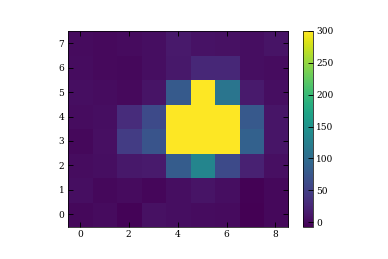

In [311]:
import matplotlib.animation as animation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook

fig = plt.figure()#figsize=(10,10))
j=0
#thingy = np.nansum(Maskdata,axis = (1,2)) != 0
test = datacube[eventtime[j][0]-20:eventtime[j][1]+20,:,:]
Maskdata2 = test#/((np.nanmedian(Maskdata, axis = (0))+3*(np.nanstd(Maskdata, axis = (0))))))>=1#[Framemin::12]
im = plt.imshow(Maskdata2[0,:,:], origin='lower',vmax=300, animated=True)
i = 0
def updatefig(*args):
    global i
    if i<Maskdata2.shape[0]+1:
        i+=1
        
    im.set_array(Maskdata2[i])
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=60, blit=True)
plt.colorbar();
#ani.save(save+pixelfile.split('/')[-1].split('-')[0]+'_'+'.gif',writer='imagemagick');
#plt.figure()
#plt.imshow(eventmask[j],origin='lower')


In [ ]:
asteroid

In [ ]:
eventtime

In [ ]:
testlc = np.nansum(datacube*obj,axis=(1,2))
testlc = datacube[:,6,2]
teststd = np.nanstd(testlc[Qual==0])
testmed = np.nanmedian(testlc[Qual==0])
print(testmed)
print(teststd/testmed)

In [ ]:
plt.figure()
plt.plot(testlc,'.')
for boom in thrusters:
    plt.axvline(boom,color='k',alpha = 0.5)#,alpha = .1)
plt.axhline(np.nanmedian(testlc)+3*np.nanstd(testlc))
#plt.axhline(np.nansum(testmed+teststd))
plt.xlim(2370,2550)

In [ ]:
np.where(testlc == np.nanmax(testlc))

In [ ]:
plt.figure()
plt.imshow(datacube[events[1]])

plt.colorbar()


In [ ]:
np.nanmax(datacube[events[0]])

## test data


In [ ]:
testtime = np.arange(2592,3000)
def LongTest(x, bright, stretch, disp):
    x = np.arange(0,x)
    y = -stretch*(x-disp)**2 + bright
    y[y<0] = 0
    return y

In [ ]:
plt.figure()
plt.plot(LongTest(time.shape[0], 1000, .001, 2000));

In [ ]:
testdata = fits.ImageHDU(hdu[1].data.field('FLUX')[:]).data
testdata[testtime,6,6] = LongTest(time.shape[0], 1000, .001, 2000)[testtime]
testdata[1000:1005,1,1] = 40

## Attempt at primative centroiding

In [ ]:
right = np.c_[np.zeros((obj.shape[0],1)),np.delete(obj*1,obj.shape[1]-1,1)]
left = np.c_[np.delete(obj*1,0,1),np.zeros((obj.shape[0],1))]
up = np.r_[np.delete(obj*1,0,0),np.zeros((1,obj.shape[1]))]
down = np.r_[np.zeros((1,obj.shape[1])),np.delete(obj*1,obj.shape[0]-1,0)]
directions = np.array((obj,right,left,up,down))

In [ ]:
directions.shape

In [ ]:
np.nanmin(abs(np.nansum(directions*datacube[events[0]],axis = (1,2)) - np.nansum(obj*datacube[events[0]],axis = (0,1))),axis = 0 )

In [ ]:
np.nansum(directions*datacube[events[0]],axis = (1,2)) - np.nansum(obj*datacube[events[0]],axis = (0,1))

In [ ]:
plt.figure()
plt.imshow(datacube[0])#*up)
plt.colorbar();

In [ ]:
test1 = abs(Maskdata[thrusters+1]-Maskdata[thrusters-1])
test = np.copy(test1)
test[(test > 100)] = np.nan

In [ ]:
i = 1
plt.figure()
plt.imshow(test[i],origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(test1[i],origin='lower')
plt.colorbar()

In [ ]:
def DriftKiller(Data,thrust):
    # The right value choice here is a bit ambiguous, though it seems that typical variations are <10.
    data = np.copy(Data)
    data[np.isnan(data)] == 0
    Drift = (abs(convolve(data[thrust+1],np.ones((1,3,3)),mode='constant', cval=0.0)-convolve(data[thrust-1],np.ones((1,3,3)),mode='constant', cval=0.0))) < 90    
    Drift = Drift*1.0
    Drift[Drift == 0] = np.nan
    j = 0
    for i in range(len(thrust)):
        data[j:thrust[i]] = data[j:thrust[i]]*Drift[i]
        j = thrust[i]
    return data


In [ ]:
Drift = (abs(Maskdata[thrusters+1]-Maskdata[thrusters-1]) < 10)*1.0 
Drift[Drift == 0] = np.nan
j = 0
testdata = np.copy(Maskdata)
for i in range(len(thrusters)):
    testdata[j:thrusters[i]] = testdata[j:thrusters[i]]*Drift[i]
    j = thrusters[i]

In [ ]:
Drift[Drift == 0] = np.nan


In [ ]:
np.where(Drift==0)

In [ ]:
plt.figure()
plt.imshow(Maskdata[20]*Drift[20],origin='lower')
plt.colorbar()

In [ ]:
test = DriftKiller(Maskdata,thrusters)

In [ ]:
i = 20
plt.figure()
plt.imshow(test[i],origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(Maskdata[i],origin='lower')
plt.colorbar()

In [ ]:
plt.figure()
plt.imshow(Maskdata[thrusters[7]-1]-Maskdata[thrusters[7]+1],origin='lower',vmin=-1000,vmax=1000)
plt.colorbar()

In [ ]:
plt.figure()
plt.imshow(Maskdata[thrusters[7]-1],origin='lower',vmin=-1000,vmax=1000)
plt.colorbar()

In [ ]:
Qual[3644]

In [ ]:
plt.figure()
plt.plot(np.nansum(Maskdata*Eventmask[events[0]], axis = (1,2)),'.')
"""for i in thrusters:
    plt.axvline(i)"""

def MinThrustframe(data,thrust):
    mean = np.nanmean(data[thrust+1],axis = 0)
    std = np.nanstd((data[thrust+1] - mean), axis = (1,2))
    Framemin = np.where(std == np.nanmin(abs(std)))
    return thrust[Framemin]+1
plt.axvline(MinThrustframe(datacube,thrusters))
#plt.xlim(800,1200);

## Looking at variations on a single pixel


In [ ]:
testLC = datacube[:,2,2]

plt.figure()
plt.plot(testLC,'.b')
for i in thrusters:
    plt.axvline(i,color = 'black')

In [ ]:
plt.figure()
plt.plot(K2Steptest(19,10,time,1000))#('/Volumes/TOSHIBA EXt/K2/c06/212200000/72000/ktwo212272599-c06_lpd-targ.fits.gz',1000))

In [ ]:
K2Steptest(19,3,time,1000)

In [ ]:
lc = datacube[:,1,2]#K2Steptest(19,10,time,1000)
middle = np.where(np.nanmax(lc[999:1011]) == lc)[0][0]
x = np.arange(middle-2,middle+2+1,1)
x2 = np.arange(0,len(x),1)
y = lc[[np.arange(middle-2,middle+2+1,1)]]
p1, residual, _, _, _ = np.polyfit(x,y,2, full = True)
p2 = np.poly1d(p1)
AvLeft = np.nansum(abs(lc[999:1011] - p2(np.arange(999,1011))))/(1011-999)

print(AvLeft)
maxpoly = np.where(np.nanmax(p2(x)) == p2(x))[0][0]
if (AvLeft < 200) &  (abs(middle - x[maxpoly]) < 2):
    asteroid = True
    if plot == True:
        p2 = np.poly1d(p1)
        plt.figure()
        plt.plot(x,lc[x],'.')
        plt.plot(x,p2(x),'.')
        plt.ylabel('Counts')
        plt.xlabel('Time')
        plt.title('Residual = ' + str(residual))

In [ ]:
lc = datacube[:,1,2]
plt.figure()
#plt.plot(p2(np.arange(999,1011)))
plt.plot(lc)

In [ ]:
datacube[:,1,2][1000]

In [ ]:
Eventmask[1006]

In [ ]:
framemask[1000]

In [ ]:
# ParabolaElim
eventtime

In [ ]:
plt.figure()
plt.plot(np.nansum(Maskdata*eventmask[events==1338][0],axis=(1,2)))
plt.xlim(eventtime[events==1338][0][0],eventtime[events==1338][1][1])
plt.ylim(0,400)

In [ ]:
events